In [1]:
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
import imblearn.over_sampling
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [12]:
cnx = create_engine('postgresql://postgres@52.90.185.96:5432/instacart')

/Users/andersolson-swanson/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [13]:

df_orders = pd.read_sql_query('''SELECT * FROM orders_sample''',cnx)
df_order_products_prior = pd.read_sql_query('''SELECT * FROM order_products_prior_sample''',cnx)
df_order_products_train = pd.read_sql_query('''SELECT * FROM order_products_train_sample''',cnx)
df_products = pd.read_sql_query('''SELECT * FROM products_full''',cnx)

In [6]:
# Pickling these files for re-import when needed


with open('orders_sample.pkl', 'wb') as picklefile:
    pickle.dump(df_orders, picklefile)
with open('order_products_prior_sample.pkl', 'wb') as picklefile:
    pickle.dump(df_order_products_prior, picklefile)
with open('order_products_train_sample.pkl', 'wb') as picklefile:
    pickle.dump(df_order_products_train, picklefile)
with open('products.pkl', 'wb') as picklefile:
    pickle.dump(df_products, picklefile)

In [11]:
with open('orders_sample.pkl', 'rb') as picklefile:
    df_orders = pickle.load(picklefile)
with open('order_products_prior_sample.pkl', 'rb') as picklefile:
    df_order_products_prior = pickle.load(picklefile)
with open('order_products_train_sample.pkl', 'rb') as picklefile:
    df_order_products_train = pickle.load(picklefile)
with open('products.pkl', 'rb') as picklefile:
    df_products = pickle.load(picklefile)

EOFError: Ran out of input

In [14]:
# Combining all tables together

df_order_products_train = df_order_products_train.merge(df_orders.drop('eval_set', axis=1), on='order_id')
df_order_products_train = df_order_products_train.merge(df_products, on='product_id')
df_order_products_prior = df_order_products_prior.merge(df_orders.drop('eval_set', axis=1), on='order_id')
df_order_products_prior = df_order_products_prior.merge(df_products, on='product_id')

In [34]:
df_user_product = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = df_order_products_train['user_id'].unique() 
df_X = df_user_product[df_user_product['user_id'].isin(train_ids)]

KeyError: 'user_id'

In [13]:
train_carts = (df_order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

In [10]:
df_order_products_prior.shape

(3171959, 15)

In [6]:
with open('orders_sample.pkl', 'wb') as picklefile:
    pickle.dump(df_orders, picklefile)
with open('order_products_prior_sample.pkl', 'wb') as picklefile:
    pickle.dump(df_order_products_prior, picklefile)
with open('order_products_train_sample.pkl', 'wb') as picklefile:
    pickle.dump(df_order_products_train, picklefile)
with open('products.pkl', 'wb') as picklefile:
    pickle.dump(df_products, picklefile)

NameError: name 'df_orders' is not defined

# Baselining

In [2]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['in_cart'], df_te['in_cart']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

    return X_tr, X_te, y_tr, y_te, df_tr

In [15]:


X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

scale = StandardScaler()
X_tr_scaled = scale.fit_transform(X_tr)
X_te_scaled = scale.transform(X_te)

In [16]:


lr = LogisticRegression()
lr.fit(X_tr_scaled, y_tr)
f1_score(lr.predict(X_te_scaled), y_te)

0.08381683477639916

In [17]:


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr, y_tr)
f1_score(rf.predict(X_te), y_te)

0.03596205578366133

# Initial Product Features

In [19]:


prod_features = ['product_total_orders','product_avg_add_to_cart_order','product_avg_order_number','product_avg_dow',\
                'product_avg_hour_of_day','product_total_times_reordered','product_reordered_rate']

df_prod_features = (df_order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean'),
                                                    ('order_number', 'mean'),
                                                    ('order_dow', 'mean'),
                                                    ('order_hour_of_day', 'mean'),
                                                    ('reordered', ['sum','mean'])])))
df_prod_features.columns = ['product_id'] + prod_features

df_X = df_X.merge(df_prod_features, on='product_id')

In [19]:
X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

scale = StandardScaler()
X_tr_scaled = scale.fit_transform(X_tr)
X_te_scaled = scale.transform(X_te)

lr = LogisticRegression()
lr.fit(X_tr_scaled, y_tr)
f1_score(lr.predict(X_te_scaled), y_te)

0.08456112152870793

In [20]:
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_tr, y_tr)
f1_score(rf.predict(X_te), y_te)

0.11832289464235847

Both improve and random forest is starting to perform better

# Initial User Features

In [21]:
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order',\
                'user_avg_dow','user_avg_hour_of_day','user_total_reordered','user_reordered_percentage']

df_user_features = (df_order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean'),
                                                    ('order_dow', 'mean'),
                                                    ('order_hour_of_day', 'mean'),
                                                    ('reordered', ['sum','mean'])])))

df_user_features.columns = ['user_id'] + user_features
df_user_features['user_avg_reordered'] = df_user_features['user_avg_cartsize'] * df_user_features['user_reordered_percentage']

df_X = df_X.merge(df_user_features, on='user_id')

In [22]:
X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

scale = StandardScaler()
X_tr_scaled = scale.fit_transform(X_tr)
X_te_scaled = scale.transform(X_te)

lr = LogisticRegression()
lr.fit(X_tr_scaled, y_tr)
f1_score(lr.predict(X_te_scaled), y_te)

0.12624555931028505

In [24]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=42)
rf.fit(X_tr, y_tr)
f1_score(rf.predict(X_te), y_te)

0.18230474700481702

Both improve

# Initial User-Product Features

In [25]:
user_prod_features = ['user_product_avg_add_to_cart_order','user_product_avg_order_dow',\
                      'user_product_avg_order_hour_of_day','user_product_avg_days_since_prior_order']

df_user_prod_features = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean'),
                                                      ('order_dow', 'mean'),
                                                      ('order_hour_of_day', 'mean'),
                                                      ('days_since_prior_order', 'mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 

df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id'])

df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 

In [26]:
# Replace NA values in the user_product_avg_days_since_prior_order column with -1 to indicate it was first purchase of item

df_X = df_X.fillna(-1)

In [29]:
X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

scale = StandardScaler()
X_tr_scaled = scale.fit_transform(X_tr)
X_te_scaled = scale.transform(X_te)

lr = LogisticRegression()
lr.fit(X_tr_scaled, y_tr)
f1_score(lr.predict(X_te_scaled), y_te)

0.22873093253656235

In [30]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=42)
rf.fit(X_tr, y_tr)
f1_score(rf.predict(X_te), y_te)

0.19935665132945152

Logistic is doing better now!

In [31]:
# Save file out to csv
df_X.to_csv('instacart_df_X_sample_features_initial.csv', index=False)

# Accounting for class imbalance

## Using oversampling

In [32]:

# randomly oversample positive samples to be 40% of targets 
ROS = imblearn.over_sampling.RandomOverSampler(ratio=.4, random_state=42) 
    
X_tr_scaled_rs, y_tr_rs = ROS.fit_sample(X_tr_scaled, y_tr)

lr = LogisticRegression() 
lr.fit(X_tr_scaled, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_te_scaled), y_te), roc_auc_score(y_te, lr.predict_proba(X_te_scaled)[:,1]))) 

lr_os = LogisticRegression() 
lr_os.fit(X_tr_scaled_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_os.predict(X_te_scaled), y_te), roc_auc_score(y_te, lr_os.predict_proba(X_te_scaled)[:,1])))

X_tr_rs, y_tr_rs = ROS.fit_sample(X_tr, y_tr)

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=42)
rf.fit(X_tr, y_tr)

print('Simple Random Forest Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(rf.predict(X_te), y_te), roc_auc_score(y_te, rf.predict_proba(X_te)[:,1]))) 

rf_o = RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=42)
rf_o.fit(X_tr_rs, y_tr_rs)

print('Random Forest Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(rf_o.predict(X_te), y_te), roc_auc_score(y_te, rf_o.predict_proba(X_te)[:,1]))) 


/Users/andersolson-swanson/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Simple Logistic Regression; Test F1: 0.229, Test AUC: 0.786
Logistic Regression on Oversampled Train Data; Test F1: 0.382, Test AUC: 0.787


/Users/andersolson-swanson/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Simple Random Forest Regression; Test F1: 0.199, Test AUC: 0.772
Random Forest Regression on Oversampled Train Data; Test F1: 0.253, Test AUC: 0.777


Helps for both, logistic is still performing better

## Using class weights

In [33]:
lr = LogisticRegression() 
lr_balanced = LogisticRegression(class_weight='balanced')
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1})

lr.fit(X_tr_scaled, y_tr)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_te_scaled), y_te), roc_auc_score(y_te, lr.predict_proba(X_te_scaled)[:,1])))

lr_balanced.fit(X_tr_scaled, y_tr)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_balanced.predict(X_te_scaled), y_te), roc_auc_score(y_te, lr_balanced.predict_proba(X_te_scaled)[:,1])))

lr_4x.fit(X_tr_scaled, y_tr)
print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_4x.predict(X_te_scaled), y_te), roc_auc_score(y_te, lr_4x.predict_proba(X_te_scaled)[:,1])))

Normal Logistic Regression Test F1: 0.229, Test AUC: 0.786
Balanced class weights Logistic Regression Test F1: 0.355, Test AUC: 0.787
4:1 class weights Logistic Regression Test F1: 0.385, Test AUC: 0.787


In [34]:
rf = RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1, n_estimators=100)
rf_4x = RandomForestClassifier(class_weight={1 : 4, 0 : 1}, random_state=42, n_jobs=-1, n_estimators=100)

rf.fit(X_tr, y_tr)
print('Normal Random Forest Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(rf.predict(X_te), y_te), roc_auc_score(y_te, rf.predict_proba(X_te)[:,1])))

rf_balanced.fit(X_tr, y_tr)
print('Balanced class weights Random Forest Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(rf_balanced.predict(X_te), y_te), roc_auc_score(y_te, rf_balanced.predict_proba(X_te)[:,1])))

rf_4x.fit(X_tr, y_tr)
print('4:1 class weights Random Forest Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(rf_4x.predict(X_te), y_te), roc_auc_score(y_te, rf_4x.predict_proba(X_te)[:,1])))

Normal Random Forest Regression Test F1: 0.199, Test AUC: 0.772
Balanced class weights Random Forest Regression Test F1: 0.156, Test AUC: 0.775
4:1 class weights Random Forest Regression Test F1: 0.164, Test AUC: 0.774


Class weights helps logistic but not random forest

# Adjusting F1 threshold

Logistic Regression Model best F1 score 0.390 at prob decision threshold >= 0.163


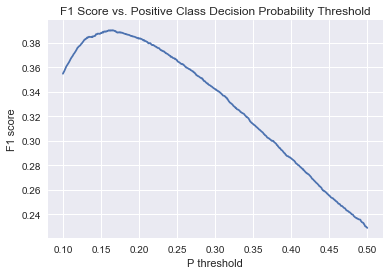

In [35]:

thresh_ps = np.linspace(.10,.50,1000)
model_te_probs = lr.predict_proba(X_te_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Random Forest Regression Model best F1 score 0.376 at prob decision threshold >= 0.220


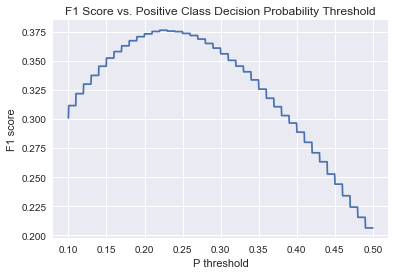

In [36]:
thresh_ps = np.linspace(.10,.50,1000)
model_te_probs = rf.predict_proba(X_te)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Changing the threshold improves both models but the logistic is still performing better.

Adjusting the F-1 score had the biggest impact

# Adding additional user-product features

In [29]:
# Adding feature for number of orders since prior time product was ordered

df_orders_since_reorder = df_order_products_prior[['product_id','user_id','order_number']]

df_orders_since_reorder = (df_orders_since_reorder.merge(df_orders_since_reorder, on=['user_id','product_id'])\
                           .sort_values(by=['user_id','order_number_x','order_number_y'], ascending=False))

df_orders_since_reorder = df_orders_since_reorder[df_orders_since_reorder['order_number_x'] > \
                                                  df_orders_since_reorder['order_number_y']]

df_orders_since_reorder = df_orders_since_reorder.groupby(['product_id', 'user_id', 'order_number_x'])\
                                                        ['order_number_y'].max().reset_index()

df_orders_since_reorder['orders_since_prior'] = df_orders_since_reorder['order_number_x'] - \
                                                df_orders_since_reorder['order_number_y']
    
df_orders_since_reorder = df_orders_since_reorder.rename(columns={'order_number_x':'order_number'})
df_orders_since_reorder = df_orders_since_reorder.drop(columns='order_number_y')

In [30]:
df_order_products_prior = df_order_products_prior.merge(df_orders_since_reorder, on=['product_id','user_id','order_number'], how='left')

In [31]:
user_prod_features2 = ['user_product_orders_since_prior']

df_user_prod_features2 = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('orders_since_prior','mean')])))

df_user_prod_features2.columns = ['product_id','user_id'] + user_prod_features2

In [32]:
df_X = df_X.merge(df_user_prod_features2,on=['user_id','product_id'])

In [33]:
df_X = df_X.fillna(-1)

In [114]:
def testing(df):
    X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
    X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

    scale = StandardScaler()
    X_tr_scaled = scale.fit_transform(X_tr)
    X_te_scaled = scale.transform(X_te)

    lr = LogisticRegression()
    lr.fit(X_tr_scaled, y_tr)
    print('Logistic Regression F1 score', f1_score(lr.predict(X_te_scaled), y_te))

    rf = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
    rf.fit(X_tr, y_tr)
    print('Random Forest F1 score', f1_score(rf.predict(X_te), y_te))

    thresh_ps = np.linspace(.10,.50,1000)
    
    model_te_probs = lr.predict_proba(X_te_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores = []
    for p in thresh_ps:
        model_te_labels = model_te_probs >= p
        f1_scores.append(f1_score(model_te_labels, y_te))

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))


    model_te_probs = rf.predict_proba(X_te)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores = []
    for p in thresh_ps:
        model_te_labels = model_te_probs >= p
        f1_scores.append(f1_score(model_te_labels, y_te))

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Random Forest Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))

In [35]:
thresh_ps = np.linspace(.10,.50,1000)

In [43]:
thresh_ps = np.linspace(.10,.50,1000)

testing(df_X)

Logistic Regression F1 score 0.22629148743044317
Random Forest F1 score 0.1971474110098492
Logistic Regression Model best F1 score 0.390 at prob decision threshold >= 0.162
Random Forest Regression Model best F1 score 0.379 at prob decision threshold >= 0.230


This improves the model slightly when changing the f1 threshold

In [36]:
# Adding feature for number of orders since user ordered product from same aisle

df_orders_since_reorder_aisle = df_order_products_prior[['product_id','user_id','order_number','aisle']]

df_orders_since_reorder_aisle = (df_orders_since_reorder_aisle.merge(df_orders_since_reorder_aisle, on=['user_id','aisle'])\
                           .sort_values(by=['user_id','order_number_x','order_number_y'], ascending=False))

df_orders_since_reorder_aisle = df_orders_since_reorder_aisle[df_orders_since_reorder_aisle['order_number_x'] > \
                                                  df_orders_since_reorder_aisle['order_number_y']]

df_orders_since_reorder_aisle = df_orders_since_reorder_aisle.groupby(['product_id_x','user_id','order_number_x','aisle'])\
                                                        ['order_number_y'].max().reset_index()

df_orders_since_reorder_aisle['orders_since_prior_aisle'] = df_orders_since_reorder_aisle['order_number_x'] - \
                                                df_orders_since_reorder_aisle['order_number_y']
    
df_orders_since_reorder_aisle = df_orders_since_reorder_aisle.rename(columns={'order_number_x':'order_number',\
                                                                             'product_id_x':'product_id'})
df_orders_since_reorder_aisle = df_orders_since_reorder_aisle.drop(columns='order_number_y')

In [37]:
df_order_products_prior = df_order_products_prior.merge(df_orders_since_reorder_aisle, on=['product_id','user_id','order_number'], how='left')

In [38]:
user_prod_features2 = ['user_product_orders_since_prior_aisle']

df_user_prod_features2 = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('orders_since_prior_aisle','mean')])))

df_user_prod_features2.columns = ['product_id','user_id'] + user_prod_features2

In [39]:
df_X = df_X.merge(df_user_prod_features2,on=['user_id','product_id'])

df_X = df_X.fillna(-1)

In [48]:
testing(df_X)

Logistic Regression F1 score 0.2267187315110638
Random Forest F1 score 0.19500594530321044
Logistic Regression Model best F1 score 0.390 at prob decision threshold >= 0.163
Random Forest Regression Model best F1 score 0.378 at prob decision threshold >= 0.210


The adjusted F1 models didn't improve.

In [40]:
df_X = df_X.drop(columns='user_product_orders_since_prior_aisle')

In [41]:
# Adding feature for number of orders since user ordered product from same department

df_orders_since_reorder_dpt = df_order_products_prior[['product_id','user_id','order_number','department']]

df_orders_since_reorder_dpt = (df_orders_since_reorder_dpt.merge(df_orders_since_reorder_dpt, on=['user_id','department'])\
                           .sort_values(by=['user_id','order_number_x','order_number_y'], ascending=False))

df_orders_since_reorder_dpt = df_orders_since_reorder_dpt[df_orders_since_reorder_dpt['order_number_x'] > \
                                                  df_orders_since_reorder_dpt['order_number_y']]

df_orders_since_reorder_dpt = df_orders_since_reorder_dpt.groupby(['product_id_x','user_id','order_number_x','department'])\
                                                        ['order_number_y'].max().reset_index()

df_orders_since_reorder_dpt['orders_since_prior_department'] = df_orders_since_reorder_dpt['order_number_x'] - \
                                                df_orders_since_reorder_dpt['order_number_y']
    
df_orders_since_reorder_dpt = df_orders_since_reorder_dpt.rename(columns={'order_number_x':'order_number',\
                                                                             'product_id_x':'product_id'})
df_orders_since_reorder_dpt = df_orders_since_reorder_dpt.drop(columns='order_number_y')

In [42]:
df_order_products_prior = df_order_products_prior.merge(df_orders_since_reorder_dpt, on=['product_id','user_id','order_number'], how='left')

In [43]:
user_prod_features2 = ['user_product_orders_since_prior_department']

df_user_prod_features2 = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('orders_since_prior_department','mean')])))

df_user_prod_features2.columns = ['product_id','user_id'] + user_prod_features2

In [44]:
df_X = df_X.merge(df_user_prod_features2,on=['user_id','product_id'])

df_X = df_X.fillna(-1)

In [54]:
testing(df_X)

Logistic Regression F1 score 0.2265267476724002
Random Forest F1 score 0.19563618533954402
Logistic Regression Model best F1 score 0.391 at prob decision threshold >= 0.162
Random Forest Regression Model best F1 score 0.379 at prob decision threshold >= 0.220


This improves the logistic model

In [45]:
# Adding feature for number of orders since user ordered product from same category

df_orders_since_reorder_cat = df_order_products_prior[['product_id','user_id','order_number','category']]

df_orders_since_reorder_cat = (df_orders_since_reorder_cat.merge(df_orders_since_reorder_cat, on=['user_id','category'])\
                           .sort_values(by=['user_id','order_number_x','order_number_y'], ascending=False))

df_orders_since_reorder_cat = df_orders_since_reorder_cat[df_orders_since_reorder_cat['order_number_x'] > \
                                                  df_orders_since_reorder_cat['order_number_y']]

df_orders_since_reorder_cat = df_orders_since_reorder_cat.groupby(['product_id_x','user_id','order_number_x','category'])\
                                                        ['order_number_y'].max().reset_index()

df_orders_since_reorder_cat['orders_since_prior_category'] = df_orders_since_reorder_cat['order_number_x'] - \
                                                df_orders_since_reorder_cat['order_number_y']
    
df_orders_since_reorder_cat = df_orders_since_reorder_cat.rename(columns={'order_number_x':'order_number',\
                                                                             'product_id_x':'product_id'})
df_orders_since_reorder_cat = df_orders_since_reorder_cat.drop(columns='order_number_y')

KeyboardInterrupt: 

In [ ]:
df_order_products_prior = df_order_products_prior.merge(df_orders_since_reorder_cat, on=['product_id','user_id','order_number'], how='left')

In [ ]:
user_prod_features2 = ['user_product_orders_since_prior_category']

df_user_prod_features2 = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('orders_since_prior_category','mean')])))

df_user_prod_features2.columns = ['product_id','user_id'] + user_prod_features2

In [ ]:
df_X = df_X.merge(df_user_prod_features2,on=['user_id','product_id'])

df_X = df_X.fillna(-1)

In [ ]:
testing(df_X)

Doesn't improve model. Will disgard

In [451]:
df_X = df_X.drop(columns='user_product_orders_since_prior_category')

# Adding more product features

In [51]:
user_current_order = df_order_products_train.groupby(['user_id', 'order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index()
user_current_order = user_current_order.drop(columns='order_id')
df_X = df_X.merge(user_current_order, on='user_id')

In [52]:
df_X['product_avg_dow_delta'] = df_X['order_dow'] - df_X['product_avg_dow']
df_X['product_avg_hod_delta'] = df_X['order_hour_of_day'] - df_X['product_avg_hour_of_day']

In [53]:
df_X = df_X.drop(columns=['order_dow', 'order_hour_of_day'])

In [54]:
testing(df_X)

Logistic Regression F1 score 0.2270163675803589
Random Forest F1 score 0.19767822105951602
Logistic Regression Model best F1 score 0.391 at prob decision threshold >= 0.163
Random Forest Regression Model best F1 score 0.380 at prob decision threshold >= 0.230


Improves models

# Adding additional user features

In [55]:
user_current_order = df_order_products_train.groupby(['user_id', 'order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index()
user_current_order = user_current_order.drop(columns='order_id')
df_X = df_X.merge(user_current_order, on='user_id')

df_X['user_avg_dow_delta'] = df_X['order_dow'] - df_X['user_avg_dow']
df_X['user_avg_hod_delta'] = df_X['order_hour_of_day'] - df_X['user_avg_hour_of_day']

df_X = df_X.drop(columns=['order_dow', 'order_hour_of_day'])

In [56]:
testing(df_X)

Logistic Regression F1 score 0.2270163675803589
Random Forest F1 score 0.19561205659216732
Logistic Regression Model best F1 score 0.391 at prob decision threshold >= 0.164
Random Forest Regression Model best F1 score 0.377 at prob decision threshold >= 0.230


In [58]:
df_X = df_X.drop(columns=['user_avg_dow_delta','user_avg_hod_delta'])

# Adding additional User-product features

In [60]:
user_current_order = df_order_products_train.groupby(['user_id', 'order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index()
user_current_order = user_current_order.drop(columns='order_id')
df_X = df_X.merge(user_current_order, on='user_id')

df_X['user_product_avg_dow_delta'] = df_X['order_dow'] - df_X['user_product_avg_order_dow']
df_X['user_product_avg_hod_delta'] = df_X['order_hour_of_day'] - df_X['user_product_avg_order_hour_of_day']

df_X = df_X.drop(columns=['order_dow', 'order_hour_of_day'])

In [61]:
testing(df_X)

Logistic Regression F1 score 0.2270163675803589
Random Forest F1 score 0.19518595973264447
Logistic Regression Model best F1 score 0.391 at prob decision threshold >= 0.164
Random Forest Regression Model best F1 score 0.379 at prob decision threshold >= 0.240


In [62]:
df_X = df_X.drop(columns=['user_product_avg_dow_delta','user_product_avg_hod_delta'])

In [63]:
df_X.to_csv('instacart_df_X_features_subset.csv', index=False)

In [4]:
df_X = pd.read_csv('instacart_df_X_features_subset.csv')

In [9]:
# Adding feature for consecutive orders

df_consecutive_orders = df_order_products_prior[['product_id','user_id','order_number']]

df_consecutive_orders = (df_consecutive_orders.merge(df_consecutive_orders, on=['user_id','product_id'])\
                           .sort_values(by=['user_id','order_number_x','order_number_y'], ascending=False))

df_consecutive_orders = df_consecutive_orders[df_consecutive_orders['order_number_x'] - \
                                                  df_consecutive_orders['order_number_y'] == 1]

df_consecutive_orders['ones'] = 1

df_consecutive_orders = df_consecutive_orders.groupby(['product_id', 'user_id'])\
                                                        ['ones'].sum().reset_index()

    
df_consecutive_orders = df_consecutive_orders.rename(columns={'ones':'consecutive_reorders'})

In [10]:
df_order_products_prior = df_order_products_prior.merge(df_consecutive_orders, on=['product_id','user_id'], how='left')

In [11]:
user_prod_features2 = ['user_product_consecutive_reorders','user_product_total_reorders']

df_user_prod_features2 = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('consecutive_reorders','sum'),
                                                      ('reordered','sum')])))

df_user_prod_features2.columns = ['product_id','user_id'] + user_prod_features2

In [12]:
df_X = df_X.merge(df_user_prod_features2,on=['user_id','product_id'])

df_X = df_X.fillna(-1)

df_X['user_product_percent_consecutive_reorders'] = df_X['user_product_consecutive_reorders'] / \
                                                    df_X['user_product_total_reorders']
    
df_X = df_X.fillna(-1)

In [77]:
testing(df_X)

Logistic Regression F1 score 0.2283943352555804
Random Forest F1 score 0.19861450692746538
Logistic Regression Model best F1 score 0.391 at prob decision threshold >= 0.163
Random Forest Regression Model best F1 score 0.379 at prob decision threshold >= 0.240


Improved simple random forest

In [19]:
df_X.to_csv('instacart_df_X_features_subset.csv', index=False)

In [57]:
#Step by step RMSEs, with .1 learning rate:
#best max_depth: 10 0.391
#best subsample: 0.7 0.393
#best min_child_weight: 10 0.394
#best colsample_bytree: 0.8
#With learning_rate set to 0.1

X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

gbm = xgb.XGBClassifier(
                        n_estimators=30000, #arbitrary large number
                        max_depth=10,
                        objective="binary:logistic",
                        learning_rate=.1, 
                        subsample=0.7,
                        min_child_weight=10,
                        colsample_bytree=0.8,
                       )

eval_set=[(X_tr,y_tr),(X_te,y_te)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_tr, y_tr, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=50,
                    verbose=False
                   )

In [58]:
f1_score(y_te, gbm.predict(X_te, ntree_limit=gbm.best_ntree_limit)) 

/Users/andersolson-swanson/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.20472505091649695

In [27]:
thresh_ps = np.linspace(.10,.50,1000)

In [59]:
model_te_probs = gbm.predict_proba(X_te, ntree_limit=gbm.best_ntree_limit)[:,1] # positive class probs, same basic logistic model we fit in section 2 
thresh_ps = np.linspace(.10,.50,1000)
f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Boosting Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Boosting Model best F1 score 0.393 at prob decision threshold >= 0.194


In [105]:
# Adding feature for number of days since prior time product was ordered

df_days_cumulative = df_order_products_prior[['user_id','order_number','days_since_prior_order']]\
                            .sort_values(by=['user_id','order_number'], ascending=False)
    
df_days_cumulative = df_days_cumulative.drop_duplicates()

df_days_cumulative['cumulative_days'] = df_days_cumulative.groupby('user_id')['days_since_prior_order'].cumsum()

# df_days_cumulative = df_days_cumulative.rename(columns={'order_number_x':'order_number',
#                                                               'user_id_x':'user_id',
#                                                               'days_since_prior_order_x':'days_since_prior_order'})




# df_days_cumulative = df_days_cumulative.rename(columns={'days_since_prior_order_y':'cumulative_sum'})



In [106]:
df_order_products_prior = df_order_products_prior.merge(df_days_cumulative, on=['user_id','order_number'], how='left')

In [107]:
user_prod_features2 = ['user_product_days_since_most_recent']

df_user_prod_features2 = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('cumulative_days','min')])))

df_user_prod_features2.columns = ['product_id','user_id'] + user_prod_features2

In [111]:
df_X = df_X.merge(df_user_prod_features2,on=['user_id','product_id'])

In [112]:
df_X = df_X.fillna(-1)

In [115]:
testing(df_X)

Logistic Regression F1 score 0.24110872535623656
Random Forest F1 score 0.24822805514448165
Logistic Regression Model best F1 score 0.421 at prob decision threshold >= 0.184
Random Forest Regression Model best F1 score 0.418 at prob decision threshold >= 0.250


Huge improvement!

In [126]:
X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

scale = StandardScaler()
X_tr_scaled = scale.fit_transform(X_tr)
X_te_scaled = scale.transform(X_te)

lr = LogisticRegression()
lr.fit(X_tr_scaled, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [129]:
df_X.to_csv('instacart_df_X_features_subset.csv', index=False)

### Try using median instead of -1 for NAs and see if results change

In [135]:
df_X_logistic = df_X.replace(to_replace=-1, value=np.nan)

df_X_logistic = df_X_logistic.fillna(df_X_logistic.median())

testing(df_X_logistic)

Logistic Regression F1 score 0.24110872535623656
Random Forest F1 score 0.24822805514448165
Logistic Regression Model best F1 score 0.421 at prob decision threshold >= 0.184
Random Forest Regression Model best F1 score 0.418 at prob decision threshold >= 0.250


They don't change. I'll stick with -1

# Add another user-product feature

In [137]:
df_X['user_product_reordered_percentage'] = df_X['user_product_total_reorders'] / df_X['user_product_total_orders']

In [139]:
testing(df_X)

Logistic Regression F1 score 0.23529411764705882
Random Forest F1 score 0.24854702188243558
Logistic Regression Model best F1 score 0.420 at prob decision threshold >= 0.203
Random Forest Regression Model best F1 score 0.417 at prob decision threshold >= 0.220


Makes the model worse

In [140]:
df_X = df_X.drop(columns='user_product_reordered_percentage')

# Adding additional product features

In [141]:
df_X2 = df_X.merge(df_products, on='product_id')

In [142]:
df_X2 = df_X2.drop(columns=['product_name', 'aisle_id', 'department_id'])

In [143]:
df_X2 = df_X2.drop(columns=['department', 'category'])
df_X2 = pd.get_dummies(df_X2, columns=['aisle'])

In [145]:
X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X2)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

scale = StandardScaler()
X_tr_scaled = scale.fit_transform(X_tr)
X_te_scaled = scale.transform(X_te)

lr = LogisticRegression()
lr.fit(X_tr_scaled, y_tr)
print('Logistic Regression F1 score', f1_score(lr.predict(X_te_scaled), y_te))

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_tr, y_tr)
print('Random Forest F1 score', f1_score(rf.predict(X_te), y_te))

thresh_ps = np.linspace(.10,.50,1000)

model_te_probs = lr.predict_proba(X_te_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))
    
best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


model_te_probs = rf.predict_proba(X_te)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))
    
best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Logistic Regression F1 score 0.24114638241380656
Random Forest F1 score 0.2275108995640174
Logistic Regression Model best F1 score 0.420 at prob decision threshold >= 0.196
Random Forest Regression Model best F1 score 0.418 at prob decision threshold >= 0.220


Random forest stays the same

In [157]:
df_X2 = df_X.merge(df_products, on='product_id')
df_X2 = df_X2.drop(columns=['product_name', 'aisle_id', 'department_id','category'])
df_X2 = pd.get_dummies(df_X2, columns=['aisle','department'])

In [158]:
X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X2)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

scale = StandardScaler()
X_tr_scaled = scale.fit_transform(X_tr)
X_te_scaled = scale.transform(X_te)

lr = LogisticRegression()
lr.fit(X_tr_scaled, y_tr)
print('Logistic Regression F1 score', f1_score(lr.predict(X_te_scaled), y_te))

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_tr, y_tr)
print('Random Forest F1 score', f1_score(rf.predict(X_te), y_te))

thresh_ps = np.linspace(.10,.50,1000)

model_te_probs = lr.predict_proba(X_te_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))
    
best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


model_te_probs = rf.predict_proba(X_te)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))
    
best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Logistic Regression F1 score 0.24114638241380656
Random Forest F1 score 0.22646493756003844
Logistic Regression Model best F1 score 0.420 at prob decision threshold >= 0.196
Random Forest Regression Model best F1 score 0.419 at prob decision threshold >= 0.230


Improved random forest

In [159]:
df_X.to_csv('instacart_df_X_features_subset.csv', index=False)
df_X2.to_csv('instacart_df_X2_features_subset.csv', index=False)

In [199]:
df_X2 = pd.read_csv('instacart_df_X2_features_subset.csv')

# Adding features for 3 most recent orders

In [164]:
df_max_order_user = (df_order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_number','max')])))

In [166]:
df_orders_user = (df_order_products_prior.groupby(['user_id','order_number'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('product_id','count')])))

df_orders_user = df_orders_user.drop(columns='product_id')

In [167]:
df_orders_user = df_orders_user.merge(df_max_order_user, on='user_id')

In [171]:
df_recent_orders = df_orders_user[df_orders_user['order_number_y'] - df_orders_user['order_number_x'] < 3]
df_recent_orders = df_recent_orders.drop(columns='order_number_y')
df_recent_orders = df_recent_orders.rename(columns={'order_number_x':'order_number'})

In [173]:
df_order_products_prior_recent = df_order_products_prior.merge(df_recent_orders, on=['user_id','order_number'])

In [200]:
prod_features = ['product_total_orders_recent','product_avg_add_to_cart_order_recent','product_avg_order_number_recent'\
                 ,'product_avg_dow_recent',\
                'product_avg_hour_of_day_recent','product_total_times_reordered_recent','product_reordered_rate_recent']

df_prod_features = (df_order_products_prior_recent.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean'),
                                                    ('order_number', 'mean'),
                                                    ('order_dow', 'mean'),
                                                    ('order_hour_of_day', 'mean'),
                                                    ('reordered', ['sum','mean'])])))
df_prod_features.columns = ['product_id'] + prod_features

df_X = df_X.merge(df_prod_features, on='product_id', how='left')
df_X2 = df_X2.merge(df_prod_features, on='product_id', how='left')

df_X = df_X.fillna(-1)
df_X2 = df_X2.fillna(-1)

In [201]:
testing(df_X)
testing(df_X2)

Logistic Regression F1 score 0.263811890651883
Random Forest F1 score 0.2569508804448563
Logistic Regression Model best F1 score 0.429 at prob decision threshold >= 0.186
Random Forest Regression Model best F1 score 0.422 at prob decision threshold >= 0.240


In [178]:
df_X = df_X.drop(columns=['product_total_orders_recent','product_avg_add_to_cart_order_recent',\
                          'product_avg_order_number_recent','product_avg_dow_recent','product_avg_hour_of_day_recent',\
                          'product_total_times_reordered_recent','product_reordered_rate_recent'])

In [203]:
user_features = ['user_total_orders_recent','user_avg_cartsize_recent','user_total_products_recent',\
                 'user_avg_days_since_prior_order_recent','user_avg_dow_recent','user_avg_hour_of_day_recent',\
                 'user_total_reordered_recent','user_reordered_percentage_recent']

df_user_features = (df_order_products_prior_recent.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order_x','mean'),
                                                    ('order_dow', 'mean'),
                                                    ('order_hour_of_day', 'mean'),
                                                    ('reordered', ['sum','mean'])])))

df_user_features.columns = ['user_id'] + user_features
df_user_features['user_avg_reordered_recent'] = df_user_features['user_avg_cartsize_recent'] * \
                        df_user_features['user_reordered_percentage_recent']

df_X = df_X.merge(df_user_features, on='user_id', how='left')
df_X2 = df_X2.merge(df_user_features, on='user_id', how='left')

df_X = df_X.fillna(-1)
df_X2 = df_X2.fillna(-1)

In [204]:
testing(df_X)
testing(df_X2)

Logistic Regression F1 score 0.263811890651883
Random Forest F1 score 0.2569508804448563
Logistic Regression Model best F1 score 0.429 at prob decision threshold >= 0.186
Random Forest Regression Model best F1 score 0.422 at prob decision threshold >= 0.240


In [205]:
df_X = df_X.drop(columns=['user_avg_cartsize_recent','user_total_products_recent',\
                 'user_avg_days_since_prior_order_recent','user_avg_dow_recent','user_avg_hour_of_day_recent',\
                 'user_total_reordered_recent','user_reordered_percentage_recent','user_avg_reordered_recent'])

df_X2 = df_X2.drop(columns=['user_avg_cartsize_recent','user_total_products_recent',\
                 'user_avg_days_since_prior_order_recent','user_avg_dow_recent','user_avg_hour_of_day_recent',\
                 'user_total_reordered_recent','user_reordered_percentage_recent','user_avg_reordered_recent'])

In [206]:
user_prod_features = ['user_product_total_orders_recent','user_product_avg_add_to_cart_order_recent',\
                      'user_product_avg_order_dow_recent',\
                      'user_product_avg_order_hour_of_day_recent','user_product_avg_days_since_prior_order_recent']

df_user_prod_features = (df_order_products_prior_recent.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('order_id','count'),
                                                      ('add_to_cart_order','mean'),
                                                      ('order_dow', 'mean'),
                                                      ('order_hour_of_day', 'mean'),
                                                      ('days_since_prior_order_x', 'mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 

df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id'], how='left')
df_X2 = df_X2.merge(df_user_prod_features,on=['user_id','product_id'], how='left')

df_X['user_product_order_freq_recent'] = df_X['user_product_total_orders_recent'] / df_X['user_total_orders_recent'] 
df_X2['user_product_order_freq_recent'] = df_X2['user_product_total_orders_recent'] / df_X2['user_total_orders_recent'] 

df_X = df_X.fillna(-1)
df_X2 = df_X2.fillna(-1)

In [207]:
testing(df_X)
testing(df_X2)

Logistic Regression F1 score 0.263811890651883
Random Forest F1 score 0.2569508804448563
Logistic Regression Model best F1 score 0.429 at prob decision threshold >= 0.186
Random Forest Regression Model best F1 score 0.422 at prob decision threshold >= 0.240
Logistic Regression F1 score 0.263811890651883
Random Forest F1 score 0.2569508804448563
Logistic Regression Model best F1 score 0.429 at prob decision threshold >= 0.186
Random Forest Regression Model best F1 score 0.422 at prob decision threshold >= 0.240


Another improvement for df_X!

In [208]:
df_X.to_csv('instacart_df_X_features_subset.csv', index=False)
df_X2.to_csv('instacart_df_X2_features_subset.csv', index=False)

In [1]:
df_X.info()

NameError: name 'df_X' is not defined